## NARPS analysis

PCA analysis on NARPS stats maps to look at potential for calibrated inference

In [16]:
import numpy as np
import pandas as pd
import nilearn
import nilearn.image
from nilearn.maskers import NiftiMasker
from pathlib import Path
import scipy.stats
import scipy.cluster
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#  use original narps code to get data
import sys
sys.path.append('/home/poldrack/Dropbox/code/narps/ImageAnalyses')
from utils import get_concat_data

In [2]:
mask = '/home/poldrack/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
resultsdir = Path("/home/poldrack/data_unsynced/NARPS_docker")

In [3]:
metadata = pd.read_csv(resultsdir / 'metadata/all_metadata.csv')

In [4]:
hypothesis_num = 1
resultfiles = sorted(resultsdir.rglob(f'output/zstat/*/hypo{hypothesis_num}_unthresh.nii.gz'))
print(f'found {len(resultfiles)} statistical maps')


found 64 statistical maps


In [5]:

imgdata, labels = get_concat_data(hyp=hypothesis_num, mask_img=mask, 
                                  output_dir = (resultsdir / 'output').as_posix(), 
                                  vox_mask_thresh=1.0)

In [6]:
cc = scipy.stats.spearmanr(imgdata.T).correlation
cc.shape

(64, 64)

row_colors: ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'y', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'k', 'y', 'm', 'm', 'm', 'm', 'y', 'm', 'm', 'm', 'k', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'k', 'm', 'm', 'y', 'm', 'm', 'm', 'm', 'k', 'm', 'm', 'k', 'y', 'y', 'm', 'k', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'y', 'm', 'm', 'm', 'k']


Text(0.5, 1.0, 'H1:')

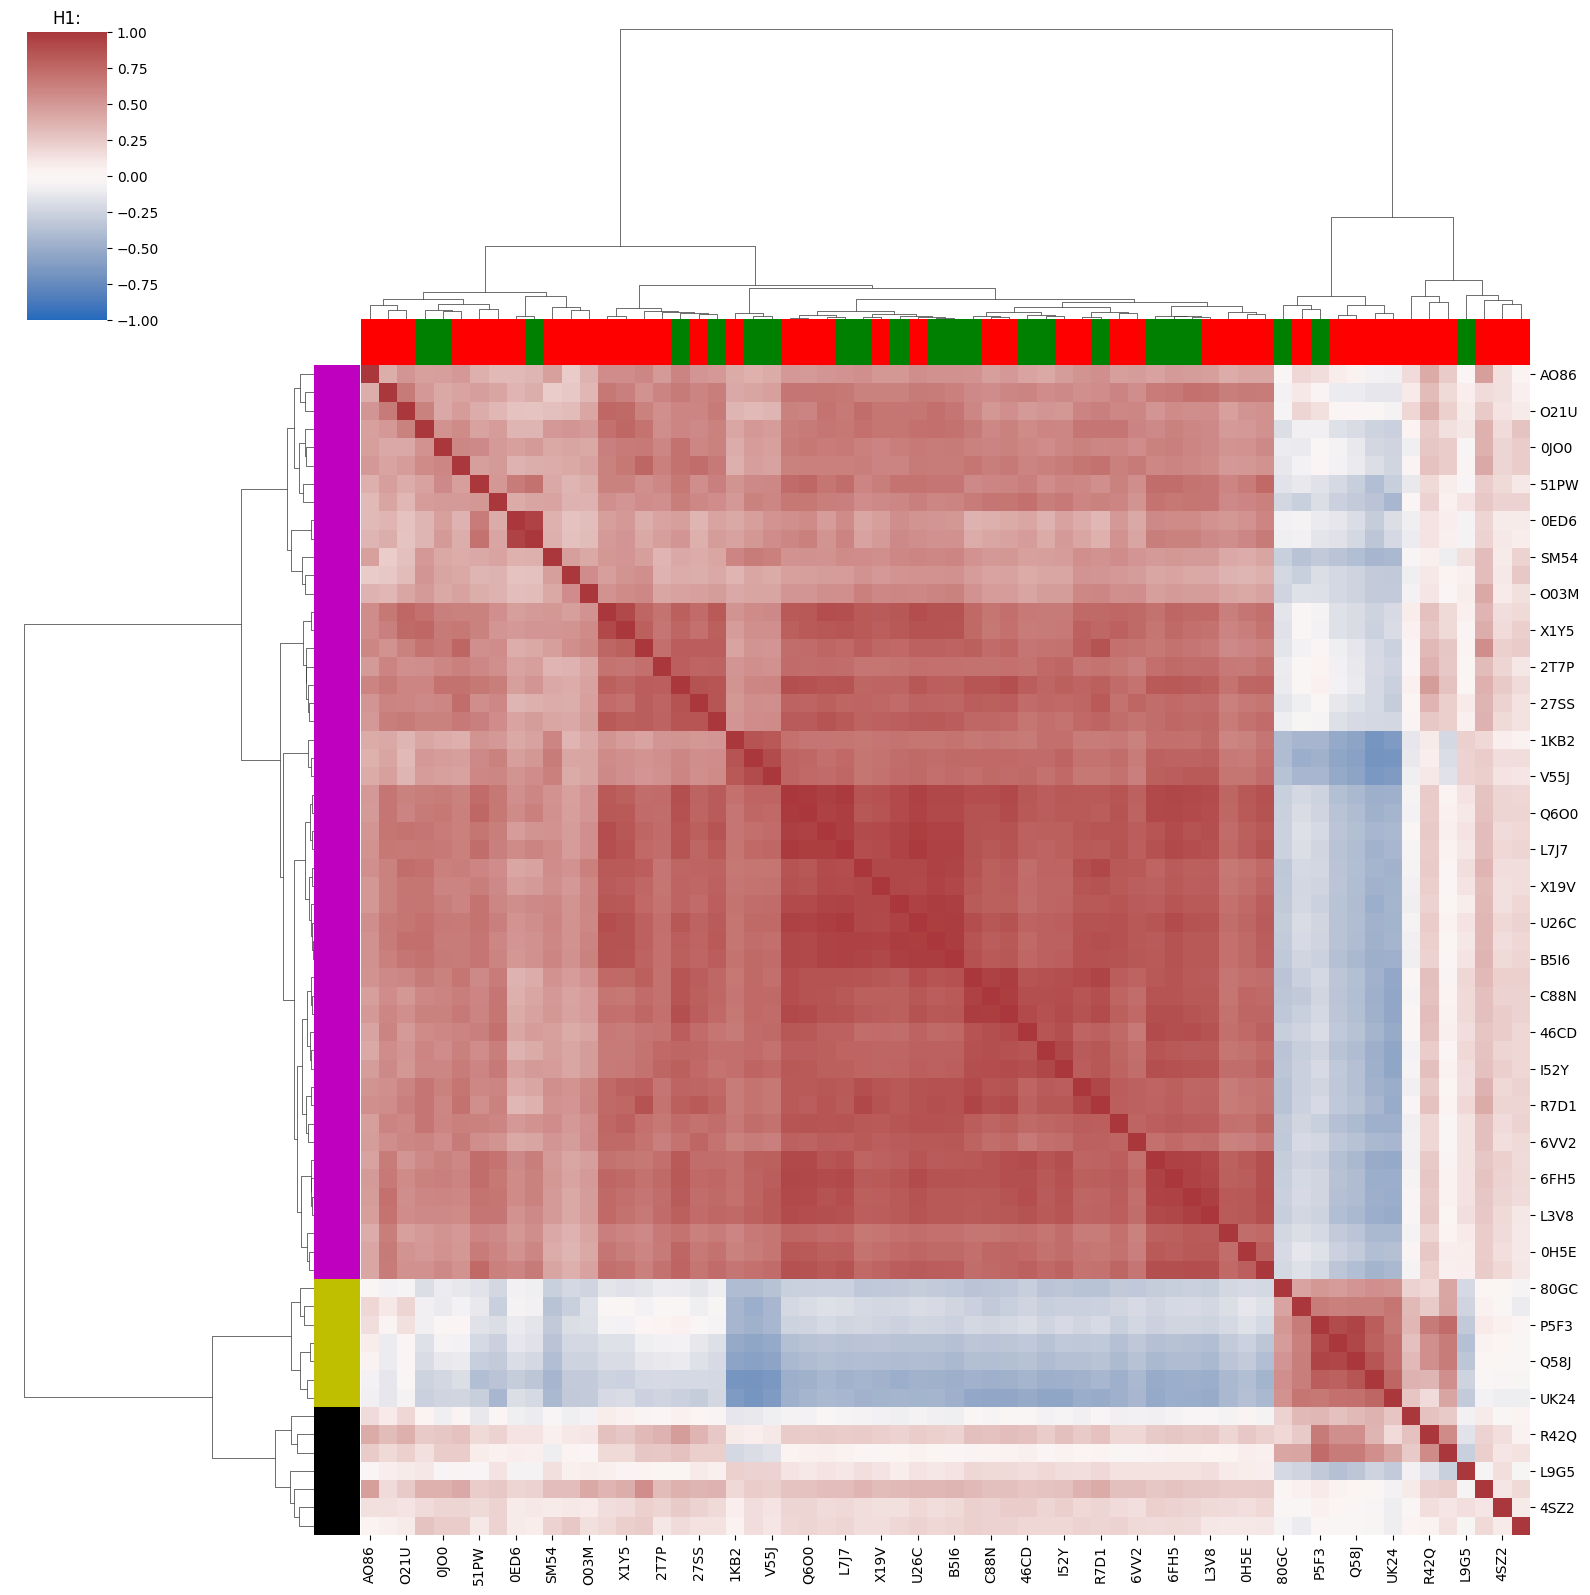

In [7]:
# following is derived from AnalyzeMaps.py

cluster_colors = ['c', 'm', 'y', 'k', 'b']
cluster_colornames = {
    'c': 'cyan',
    'm': 'magenta',
    'b': 'blue',
    'y': 'yellow',
    'k': 'black'}

ward_linkage = scipy.cluster.hierarchy.ward(cc)

df = pd.DataFrame(cc, index=labels, columns=labels)
    
# add 1 to cluster labels so they start at 1
# rather than zero - for clarity in paper
clustlabels = [
    s[0] + 1 for s in
    scipy.cluster.hierarchy.cut_tree(
        ward_linkage,
        n_clusters=3)]

# get decisions for column colors
md = metadata.query(
    'varnum==%d' % hypothesis_num).set_index('teamID')

decision_colors = ['r', 'g']
col_colors = [
    decision_colors[md.loc[teamID, 'Decision']]
    for teamID in labels
    ]

row_colors = [cluster_colors[s] for s in clustlabels]
print('row_colors:', row_colors)
cm = sns.clustermap(
    df,
    cmap='vlag',
    figsize=(16, 16),
    method='ward',
    row_colors=row_colors,
    col_colors=col_colors,
    center=0,
    vmin=-1,
    vmax=1)
plt.title('H%d:' % hypothesis_num)



In [15]:
# extract data from main cluster, since others cannot be trusted to be correct

imgdata_good = imgdata[np.array(clustlabels)==1, :]
imgdata_good.shape

(50, 142499)

In [25]:
pca = PCA(n_components=10)

In [26]:
pca.fit(imgdata)

PCA(n_components=10)

Text(0.5, 0, 'Component number')

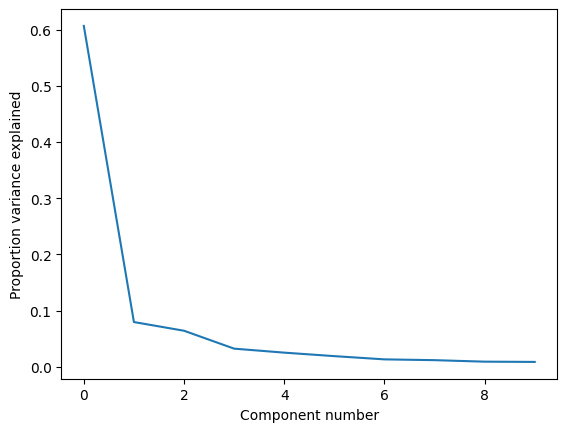

In [28]:
sns.lineplot(x=np.arange(pca.n_components), y=pca.explained_variance_ratio_)
plt.ylabel('Proportion variance explained')
plt.xlabel('Component number')